# Deep Convolutional Generative Adversarial Network

## Import modules

In [ ]:
import os
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as dset
import torchvision.utils as utils
import matplotlib.pyplot as plt
import numpy as np
import imageio
from torchvision.utils import make_grid
from torchvision import transforms

## Set Hyperparameters

In [ ]:
#########################
max_epoch = 10
learning_rate = 0.001
batch_size = 128
image_size = 128
beta_1 = 0.5
beta_2 = 0.999
# picture -> 128x128x3
#########################
# Decide which device we want to run on
device = torch.device("cuda")
# Number of workers for dataloader
workers = 2

## Construct Data

In [ ]:
! mkdir -p ~/.kaggle

In [ ]:
! cp /kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! ls -al ~/

total 64
drwx------ 1 root root 4096 Sep 13 05:31 .
drwxr-xr-x 1 root root 4096 Sep 13 05:30 ..
-r-xr-xr-x 1 root root 1169 Jan  1  2000 .bashrc
drwxr-xr-x 1 root root 4096 Sep  9 13:20 .cache
drwxr-xr-x 1 root root 4096 Sep  9 13:18 .config
drwxr-xr-x 3 root root 4096 Sep  1 19:26 .gsutil
drwxr-xr-x 5 root root 4096 Sep  9 13:17 .ipython
drwx------ 2 root root 4096 Sep  9 13:17 .jupyter
drwxr-xr-x 2 root root 4096 Sep 13 05:31 .kaggle
drwxr-xr-x 2 root root 4096 Sep 13 05:23 .keras
drwx------ 1 root root 4096 Sep  9 13:17 .local
drwxr-xr-x 4 root root 4096 Sep  9 13:18 .npm
-rw-r--r-- 1 root root  148 Aug 17  2015 .profile
-r-xr-xr-x 1 root root  254 Jan  1  2000 .tmux.conf


In [ ]:
! kaggle datasets download jessicali9530/celeba-dataset

 99% 1.32G/1.33G [00:26<00:00, 72.0MB/s]
100% 1.33G/1.33G [00:26<00:00, 53.0MB/s]


In [ ]:
! unzip celeba-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: img_align_celeba/img_align_celeba/197604.jpg  
  inflating: img_align_celeba/img_align_celeba/197605.jpg  
  inflating: img_align_celeba/img_align_celeba/197606.jpg  
  inflating: img_align_celeba/img_align_celeba/197607.jpg  
  inflating: img_align_celeba/img_align_celeba/197608.jpg  
  inflating: img_align_celeba/img_align_celeba/197609.jpg  
  inflating: img_align_celeba/img_align_celeba/197610.jpg  
  inflating: img_align_celeba/img_align_celeba/197611.jpg  
  inflating: img_align_celeba/img_align_celeba/197612.jpg  
  inflating: img_align_celeba/img_align_celeba/197613.jpg  
  inflating: img_align_celeba/img_align_celeba/197614.jpg  
  inflating: img_align_celeba/img_align_celeba/197615.jpg  
  inflating: img_align_celeba/img_align_celeba/197616.jpg  
  inflating: img_align_celeba/img_align_celeba/197617.jpg  
  inflating: img_align_celeba/img_align_celeba/197618.jpg  
  inflating: img_align_celeba/img_align_celeba/19

In [ ]:
data_dir = os.path.join('./img_align_celeba')
#A preprocessing step to convert 218x178 to 128x128
dataset = dset.ImageFolder(root=data_dir,
                           transform=transforms.Compose([
                                                         transforms.Resize(image_size),
                                                         transforms.CenterCrop(image_size),
                                                         transforms.ToTensor(),
                                                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                           ]))
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

In [ ]:
real_label = 1.
fake_label = 0.

In [ ]:
fixed_noise = torch.randn(64, 100, 1, 1, device=device)

## Define a Model

In [ ]:
# Generator Code
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            # state size. 100 x 1 x 1
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # state size. 512 x 4 x 4
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # state size. 256 x 8 x 8
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # state size. 128 x 16 x 16
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # state size. 64 x 32 x 32
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            # state size. 32 x 64 x 64
            nn.ConvTranspose2d(32, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. 3 x 128 x 128
        )

    def forward(self, input):
        return self.main(input)

# Discriminator Code
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is 3 x 128 x 128
            nn.Conv2d(3, 32, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 32 x 64 x 64
            nn.Conv2d(32, 64 , 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 64 x 32 x 32
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 128 x 16 x 16
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 256 x 8 x 8
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 512 x 4 x 4
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


## Initilize the model and optimizer

In [ ]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
def save_gif(training_progress_images, images):
    '''
        training_progress_images: list of training images generated each iteration
        images: image that is generated in this iteration
    '''
    img_grid = make_grid(images.data)
    img_grid = np.transpose(img_grid.detach().cpu().numpy(), (1, 2, 0))
    img_grid = 255. * img_grid
    img_grid = img_grid.astype(np.uint8)
    training_progress_images.append(img_grid)
    imageio.mimsave('./training_progress.gif', training_progress_images)
    return training_progress_images

In [ ]:
# Create the generator
netG = Generator().to(device)
netG.apply(weights_init)

# Create the Discriminator
netD = Discriminator().to(device)
netD.apply(weights_init)

# Initialize BCELoss function
loss = nn.BCELoss()
# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=learning_rate, betas=(beta_1, beta_2))
optimizerG = optim.Adam(netG.parameters(), lr=learning_rate, betas=(beta_1, beta_2))

## Training Procedure

In [ ]:
img_list = []
G_losses = []
D_losses = []
training_progress_images_list = []
iters = 0

In [ ]:
for epoch in range(max_epoch):
        # For each batch in the dataloader
        for i, data in enumerate(data_loader, 0):

            ############################
            # (1) Update D network: minimize - log(D(x))  +- log(1 - D(G(z)))
            ###########################
            ## Train with all-real batch
            netD.zero_grad()
            # Format batch
            real = data[0].to(device)
            label = torch.full((batch_size,), real_label, device=device)
            # Forward pass real batch through D
            output = netD(real).view(-1)
            # Calculate loss on all-real batch
            errD_real = loss(output, label)
            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = output.mean().item()

            ## Train with all-fake batch
            # Generate batch of latent vectors
            noise = torch.randn(batch_size, 100, 1, 1, device=device)
            # Generate fake image batch with G
            fake = netG(noise)
            label.fill_(fake_label)
            # Classify all fake batch with D
            output = netD(fake.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
            errD_fake = loss(output, label)
            # Calculate the gradients for this batch
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            # Add the gradients from the all-real and all-fake batches
            errD = errD_real + errD_fake
            # Update D
            optimizerD.step()

            ############################
            # (2) Update G network: minimize log(D(G(z)))
            ###########################
            netG.zero_grad()
            label.fill_(real_label)  # fake labels are real for generator cost
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = netD(fake).view(-1)
            # Calculate G's loss based on this output
            errG = loss(output, label)
            # Calculate gradients for G
            errG.backward()
            D_G_z2 = output.mean().item()
            # Update G
            optimizerG.step()

            # Output training stats
            if i % 500 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                    % (epoch, max_epoch, i, len(data_loader),
                        errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))


                #save the output
                fake = netG(fixed_noise)
                training_progress_images_list = save_gif(training_progress_images_list, fake)  # Save fake image while training!
        
                # Check pointing for every epoch
                torch.save(netG.state_dict(), './netG_epoch_%d.pth' % (epoch))
                torch.save(netD.state_dict(), './netD_epoch_%d.pth' % (epoch))

[0/10][0/1583]	Loss_D: 1.6001	Loss_G: 24.4592	D(x): 0.5849	D(G(z)): 0.5593 / 0.0000
[0/10][500/1583]	Loss_D: 1.0669	Loss_G: 0.7590	D(x): 0.5559	D(G(z)): 0.3098 / 0.5193
[0/10][1000/1583]	Loss_D: 1.1242	Loss_G: 2.0578	D(x): 0.5853	D(G(z)): 0.3960 / 0.1449
[0/10][1500/1583]	Loss_D: 1.0855	Loss_G: 2.6269	D(x): 0.8146	D(G(z)): 0.5296 / 0.1005
[1/10][0/1583]	Loss_D: 0.8942	Loss_G: 1.5219	D(x): 0.5468	D(G(z)): 0.1338 / 0.2643
[1/10][500/1583]	Loss_D: 1.4438	Loss_G: 1.5874	D(x): 0.3710	D(G(z)): 0.1944 / 0.2801
[1/10][1000/1583]	Loss_D: 0.8574	Loss_G: 2.4569	D(x): 0.7601	D(G(z)): 0.3787 / 0.1208
[1/10][1500/1583]	Loss_D: 1.1038	Loss_G: 3.2982	D(x): 0.7152	D(G(z)): 0.4639 / 0.0536
[2/10][0/1583]	Loss_D: 1.0195	Loss_G: 4.4005	D(x): 0.8157	D(G(z)): 0.4907 / 0.0180
[2/10][500/1583]	Loss_D: 1.4981	Loss_G: 1.0742	D(x): 0.3321	D(G(z)): 0.0857 / 0.3842
[2/10][1000/1583]	Loss_D: 1.1509	Loss_G: 2.3223	D(x): 0.6936	D(G(z)): 0.4787 / 0.1256
[2/10][1500/1583]	Loss_D: 0.8473	Loss_G: 1.5280	D(x): 0.5821	D(G(

In [ ]:
fixed_noise.shape

torch.Size([64, 100, 1, 1])

In [ ]:
! mkdir -p ./img/fake

In [ ]:
def save_image_list(dataset):

    base_path = './img/fake'
    
    dataset_path = []
    
    for i in range(len(dataset)):
        save_path =  f'{base_path}/image_{i}.png'
        dataset_path.append(save_path)
        utils.save_image(dataset[i], save_path)
    
    return base_path

In [ ]:
noise = torch.randn(64, 100, 1, 1, device=device)
fake_dataset = netG(noise)

In [ ]:
fake_image_path_list = save_image_list(fake_dataset)

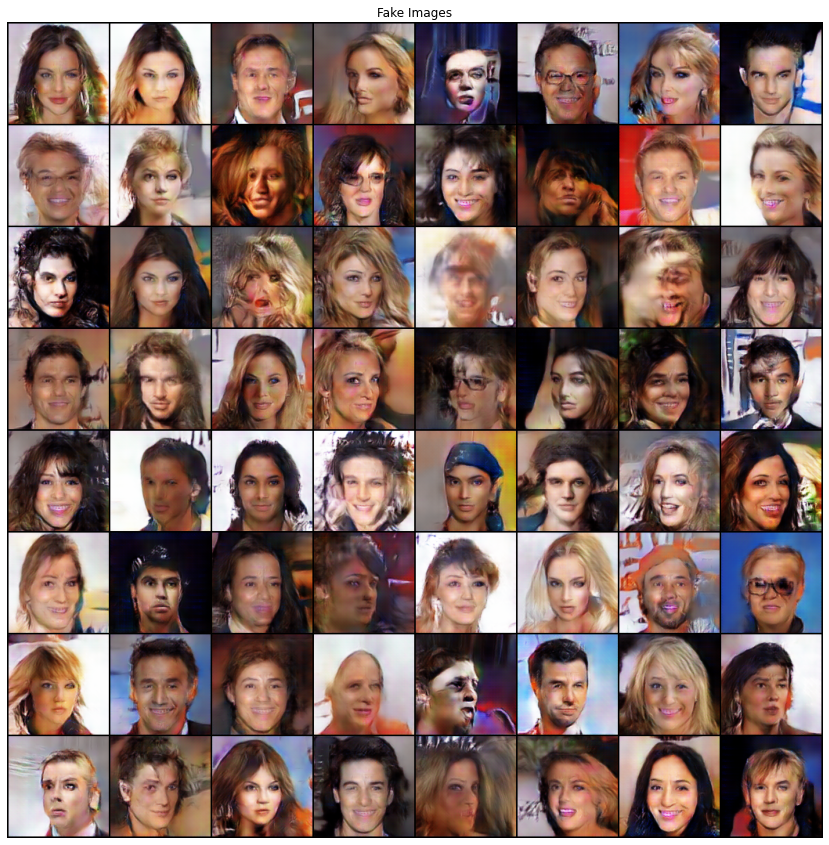

In [ ]:
plt.figure(figsize=(15,15))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(utils.make_grid(fake_dataset.to(device), padding=2, normalize=True).cpu(),(1,2,0)))
plt.savefig('fake.png')

In [ ]:
! ls

celeba-dataset.zip		 netD_epoch_2.pth  netG_epoch_2.pth
fake.png			 netD_epoch_3.pth  netG_epoch_3.pth
img				 netD_epoch_4.pth  netG_epoch_4.pth
img_align_celeba		 netD_epoch_5.pth  netG_epoch_5.pth
list_attr_celeba.csv		 netD_epoch_6.pth  netG_epoch_6.pth
list_bbox_celeba.csv		 netD_epoch_7.pth  netG_epoch_7.pth
list_eval_partition.csv		 netD_epoch_8.pth  netG_epoch_8.pth
list_landmarks_align_celeba.csv  netD_epoch_9.pth  netG_epoch_9.pth
netD_epoch_0.pth		 netG_epoch_0.pth  sample_data
netD_epoch_1.pth		 netG_epoch_1.pth  training_progress.gif


In [ ]:
from google.colab import drive

drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
! cp -r ./img/* /gdrive/MyDrive/Experiments/